In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import load_model

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Carga todos los links a las imagenes, hasta adentro de las carpetas, es decir, en este caso accesa todas las direcciones de todas las imagenes de las 3 carpetas: cats, dogs y panda.

In [0]:
mypath = "/content/drive/My Drive/data/catdogpanda/animals" # 3000 images
print(mypath)

/content/drive/My Drive/data/catdogpanda/animals


In [0]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(mypath))

[INFO] loading images...


In [0]:
print(len(imagePaths))

3000


In [0]:
for k in range(4):
  print(imagePaths[k])

/content/drive/My Drive/data/catdogpanda/animals/cats/cats_00163.jpg
/content/drive/My Drive/data/catdogpanda/animals/cats/cats_00876.jpg
/content/drive/My Drive/data/catdogpanda/animals/cats/cats_00579.jpg
/content/drive/My Drive/data/catdogpanda/animals/cats/cats_00465.jpg


Uso la "k" con valores peque#os para pruebas... comentala para cargar las 3 mil imagenes...

In [0]:
data = [] 
labels = []

k = 0
#tt = time.time

for imagePath in imagePaths:
  if k>99:
    break
  k += 1

  # extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]

  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (64, 64))  # esto ya sustituye al target_size(150,150) de F. Chollet
 
  labels.append(label)
  data.append(image)

#print(time.time - tt)

In [0]:
print(len(data))
print(len(labels))
print(labels[0])

100
100
cats


Cargando solo unos cientos de imágenes de las 3 clases:

In [0]:
labels = []
data = [] 

for j in [0,1000,2000]: # cats, dogs & pandas
  for k in range(0,100):
    label = imagePaths[k+j].split(os.path.sep)[-2]
    image = cv2.imread(imagePaths[k+j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64, 64))  # esto ya sustituye al target_size(150,150) de F. Chollet
    
    labels.append(label)
    data.append(image)


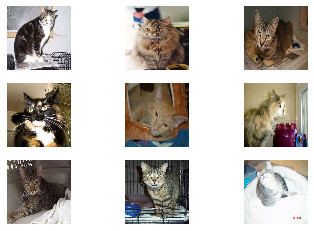

In [0]:
for i in range(0,9):
	# define subplot
  plt.subplot(330 + 1 + i) # 3 rows, 3 cols, index: 331, 332, 333, ..., 339.
  plt.imshow(data[i])
  plt.axis('off')

plt.show()

In [0]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [0]:
print(labels)

In [0]:
classnames, indices = np.unique(labels, return_inverse=True)
ylabels = tf.keras.utils.to_categorical(indices)

In [0]:
print(ylabels)

In [0]:
datax = np.array(data) 

In [0]:
datax = np.array(data)

In [0]:
(trainX, testX, trainY, testY) = train_test_split(datax, ylabels,
	test_size=0.20, random_state=42)  # stratify=ylabels

In [0]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(240, 64, 64, 3)
(60, 64, 64, 3)
(240, 3)
(60, 3)


In [0]:
print(testY)

In [0]:
datagen = ImageDataGenerator(rescale=1./255) # sin DataAugmentation

In [0]:
n_batch = 20

In [0]:
def extract_features(dataf, labelsf, n_batch):
  n_sample = len(dataf)
  featuresxx = np.zeros(shape=(n_sample, 2,2,512))
  labelsxx = np.zeros(shape=(n_sample,3))

  generator = datagen.flow(x=dataf, y=labelsf, batch_size=n_batch)  

  i=0

  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    featuresxx[i * n_batch : (i+1) * n_batch] = features_batch
    labelsxx[i * n_batch : (i+1) * n_batch] = labels_batch
    i += 1
    if i*n_batch >= n_sample:
      break

  return featuresxx, labelsxx

In [0]:
train_features, train_labels = extract_features(trainX,trainY, n_batch)

In [0]:
test_features, test_labels = extract_features(testX,testY, n_batch)

In [0]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(240, 2, 2, 512)
(60, 2, 2, 512)
(240, 3)
(60, 3)


Hay que transformarlo a vectores unidimensionales, para usarlos como vector de features:

In [0]:
train_features = np.reshape(train_features, (len(train_features), 2*2*512))

In [0]:
test_features = np.reshape(test_features, (len(test_features), 2*2*512))

In [0]:
print(train_features.shape)
print(test_features.shape)

(240, 2048)
(60, 2048)


Pasemos ahora generar un modelo de clasificación con dichos datos convertidos en features de los cats/dogs/pandas

#Modelo
Definimos un red neuronal sencilla de una capa oculta con 256 neuronas:

In [0]:
n_epochs=60
learning_rate=0.0001

In [0]:
model = tf.keras.models.Sequential([
   tf.keras.layers.Dense(256, activation='relu', input_dim=2*2*512),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [0]:
opt = tf.keras.optimizers.SGD(lr=learning_rate, decay=learning_rate / n_epochs, momentum=0.9, nesterov=True )

In [0]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
H = model.fit(train_features, train_labels, 
              epochs=n_epochs, batch_size=n_batch, 
              validation_data=(test_features,test_labels))

In [0]:
predictions = model.predict(test_features, batch_size=n_batch)

In [0]:
model.summary() 

In [0]:
labels = ["cat","dog","panda"]

In [0]:
print(classification_report(test_labels.argmax(axis=1),
      predictions.argmax(axis=1),target_names=labels))

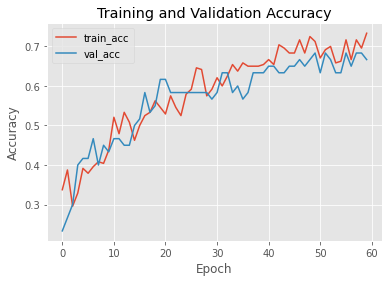

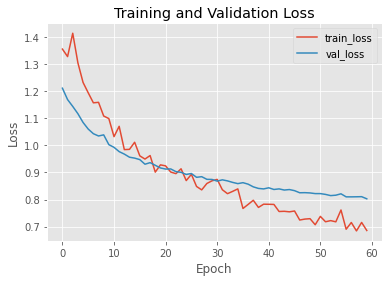

In [0]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,n_epochs),H.history["val_accuracy"],label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["loss"],label="train_loss") 
plt.plot(np.arange(0,n_epochs),H.history["val_loss"],label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [0]:
confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))

array([[15,  6,  1],
       [ 3,  7,  6],
       [ 2,  2, 18]])

In [0]:
scores=model.evaluate(test_features,test_labels,verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2/2 [==============================] - 0s 3ms/step - loss: 0.8026 - accuracy: 0.6667
Test loss: 0.8025782108306885
Test accuracy: 0.6666666865348816


Podemos gurdar nuestro modelo...

In [0]:
model.save("mimodelo.h5")

Y posteriormente lo podemos utilizar.
Observa que se guarda tu modelo, no el VGG16, es tendría que guardarlo aparte, aunque en keras lo puedes accesar directamente.

In [0]:
mymodel = tf.keras.models.load_model("/content/mimodelo.h5")


In [0]:
mymodel.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 771       
Total params: 525,315
Trainable params: 525,315
Non-trainable params: 0
_________________________________________________________________


Probemos con algunas imágenes que no están en el dataset original de entrenamiento:

In [0]:
from PIL import Image
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [0]:
pathx = '/content/drive/My Drive/Fotos_varias/animal_test3.jpg'

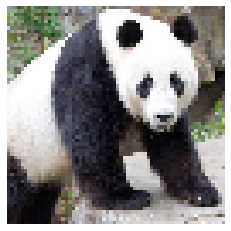

In [0]:
mitest = image.load_img(pathx, target_size=(64, 64))
plt.imshow(mitest)
plt.axis('off')
plt.show()

Le damos el formato para introducirlo primero en el VGG16 truncado:

In [0]:
mitest_arr = image.img_to_array(mitest)
mitest_arr = mitest_arr / 255.0
mitest_arr = np.expand_dims(mitest_arr, axis=0)
mitest_arr = preprocess_input(mitest_arr)
print(mitest_arr.shape)

(1, 64, 64, 3)


In [0]:
mitest_outin = conv_base.predict(mitest_arr)
print(mitest_outin.shape)

(1, 2, 2, 512)


Así, la salida del VGG16 son los features de la imagen, y la hacemos flat antes de introducirla a nuestro modelo de red neuronal sencilla:

In [0]:
mitest_outin = np.reshape(mitest_outin, (1, 2*2*512))

In [0]:
predictions_mimodelo = mymodel.predict(mitest_outin)
print(predictions_mimodelo)

[[1.5861531e-01 3.2904267e-04 8.4105563e-01]]


O bien, hagamos algunas predicciones de algunas imágenes del Test-set

In [0]:
CLASSES = np.array(['cats','dog','panda'])

preds = model.predict(test_features)
preds_single = CLASSES[np.argmax(preds,axis=-1)]
actual_single = CLASSES[np.argmax(testY,axis=-1)]

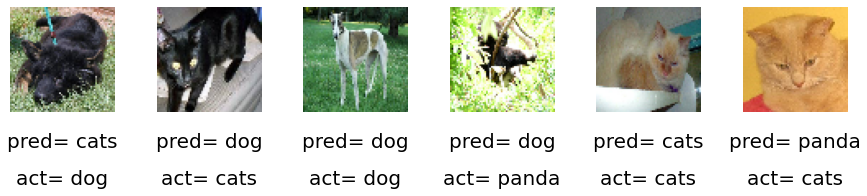

In [0]:
n_to_show = 6
indices = np.random.choice(range(len(test_features)), n_to_show)

fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace=0.4,wspace=0.4)

for i, idx, in enumerate(indices):
  img = testX[idx]
  ax = fig.add_subplot(1,n_to_show, i+1)
  ax.axis('off')
  ax.text(0.5,-0.35,'pred= '+str(preds_single[idx]), fontsize=20,ha='center',transform=ax.transAxes)
  ax.text(0.5,-0.7,'act= '+str(actual_single[idx]), fontsize=20,ha='center',transform=ax.transAxes)
  ax.imshow(img)